Epoch 1, Loss: 0.7008
⚠️ QNN predicted only one cluster. Skipping silhouette score.
KMeans Silhouette Score: 0.388


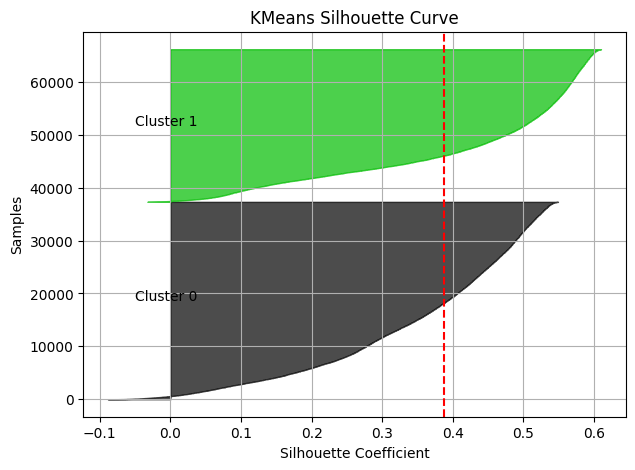

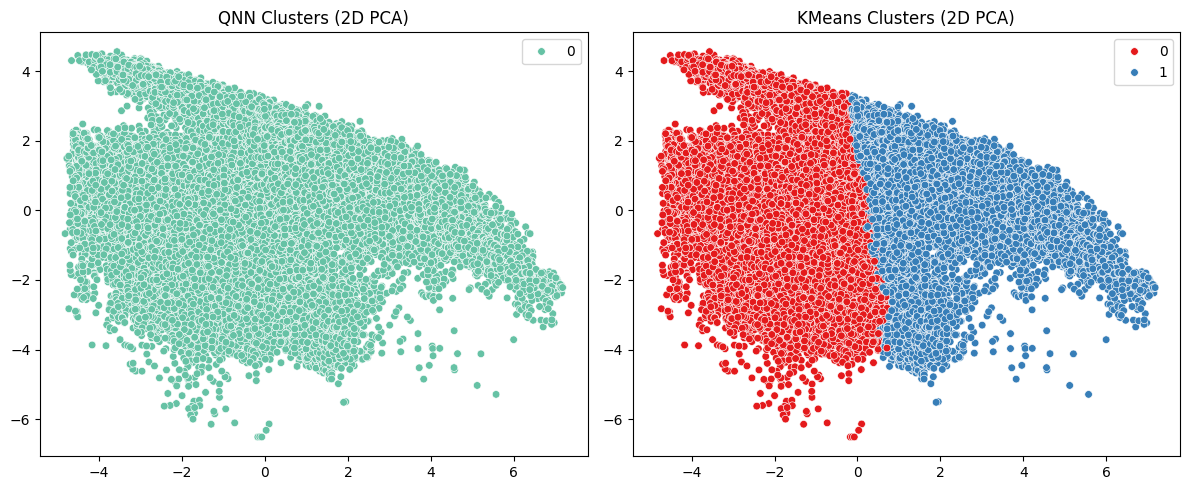

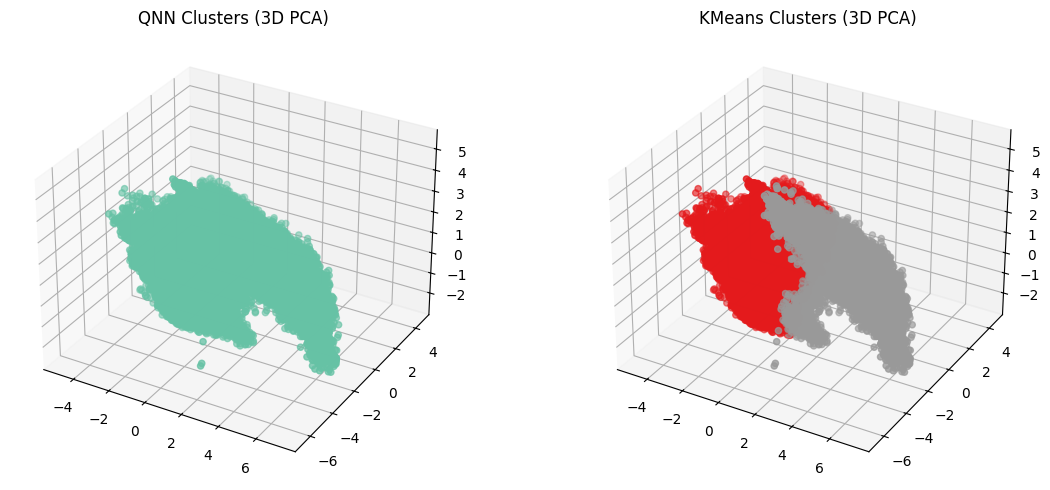

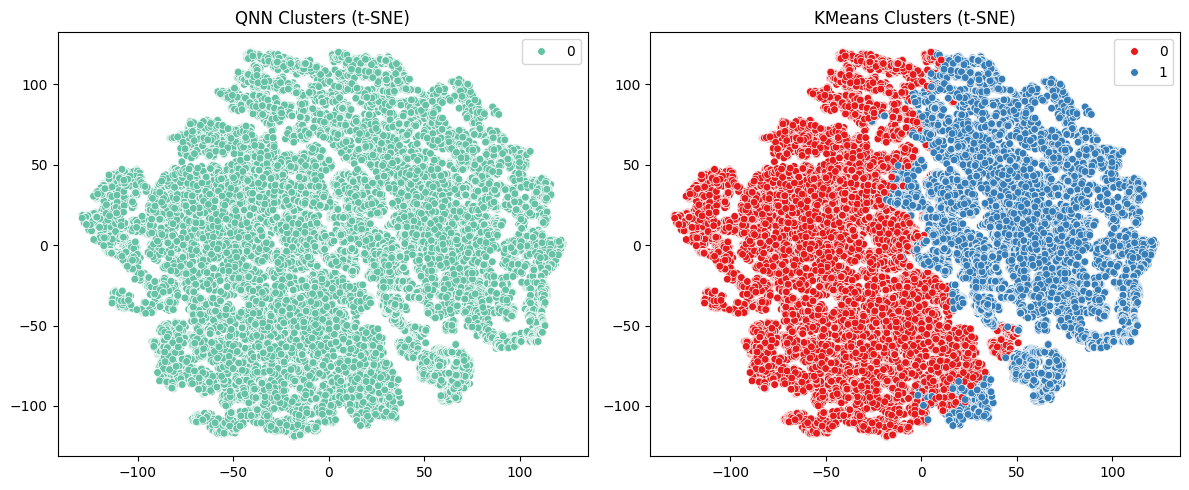

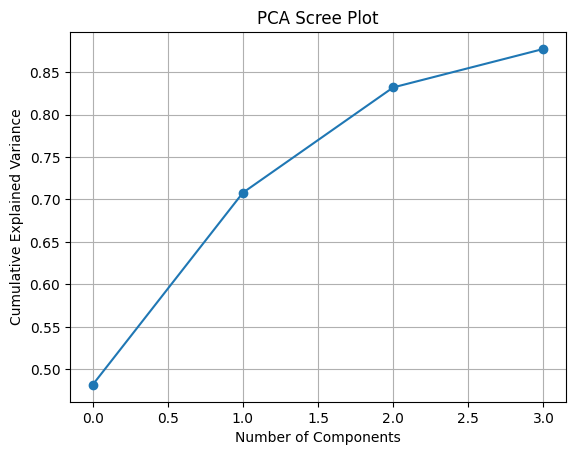

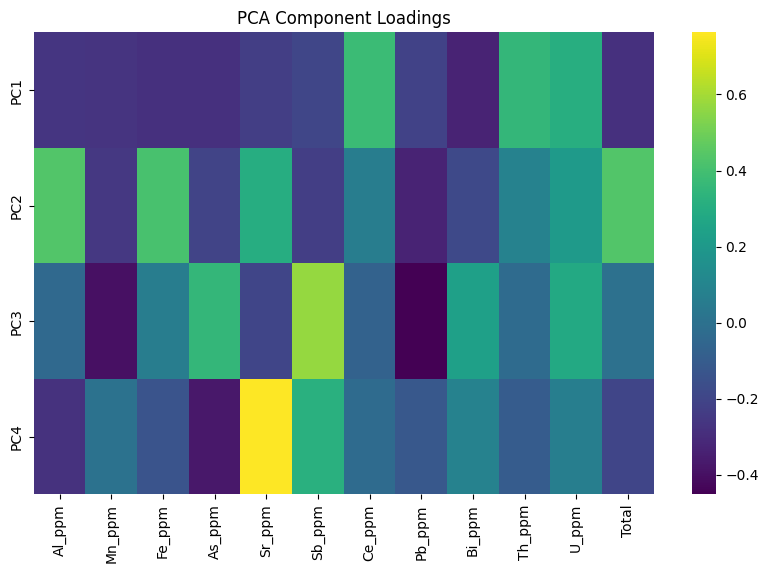

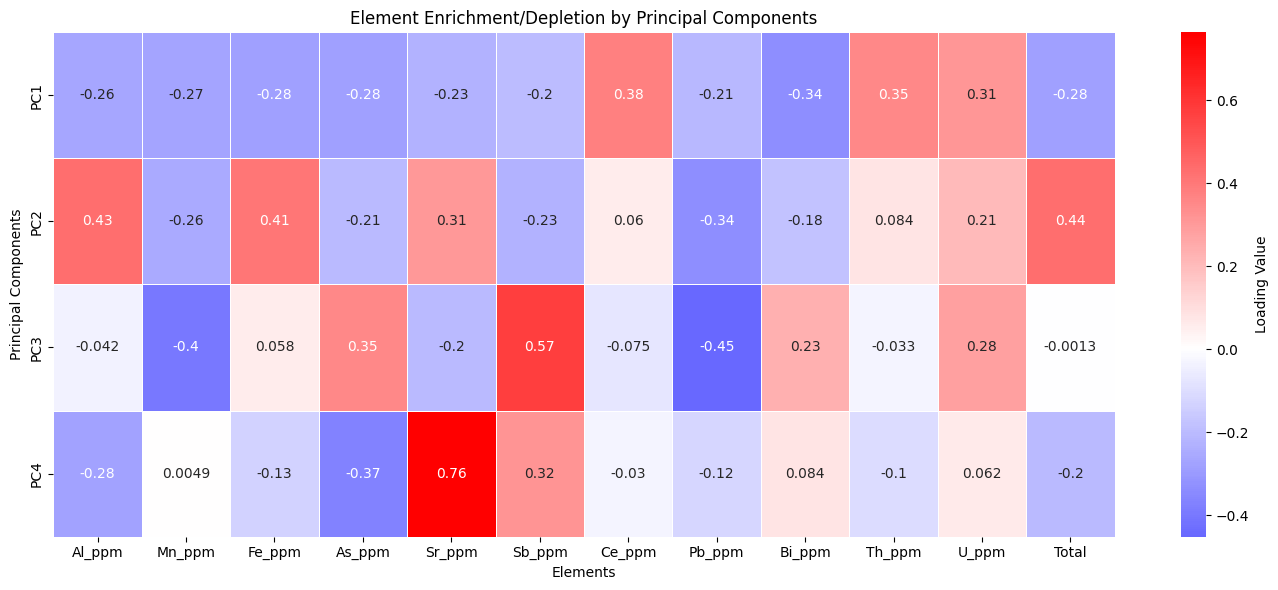

C:\Users\abhis\AppData\Local\Temp\ipykernel_21476\2036764599.py:208: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


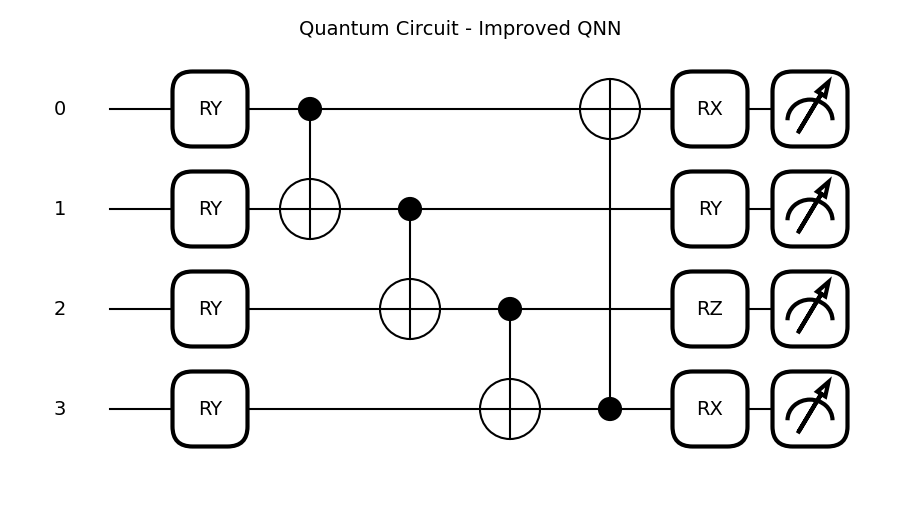

In [2]:
import pandas as pd
import numpy as np
import random
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import pennylane as qml
from mpl_toolkits.mplot3d import Axes3D
from pennylane import draw_mpl

# Set reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Load and preprocess data
df = pd.read_excel("LA-ICP-MS data.xlsx", sheet_name="Sheet0")
df_numeric = df.drop(columns=["Sample ID", "x", "y"])
df_filled = df_numeric.fillna(df_numeric.mean())

# CLR Transform
def clr_transform(df):
    log_data = np.log(df + 1e-9)
    gm = np.mean(log_data, axis=1).reshape(-1, 1)
    return log_data - gm

clr_data = clr_transform(df_filled.values)

# Standardize
data_scaled = StandardScaler().fit_transform(clr_data)

# PCA
data_pca = PCA(n_components=4, random_state=42).fit_transform(data_scaled)

# Pseudo-labels using scalable KMeans
y_pseudo = KMeans(n_clusters=2, random_state=42).fit_predict(data_pca)

# Quantum device
dev = qml.device("default.qubit", wires=4)

@qml.qnode(dev, interface="torch")
def quantum_net(inputs, weights):
    for i in range(4):
        qml.RY(inputs[i], wires=i)
    for i in range(3):
        qml.CNOT(wires=[i, i + 1])
    qml.CNOT(wires=[3, 0])
    qml.RX(weights[0], wires=0)
    qml.RY(weights[1], wires=1)
    qml.RZ(weights[2], wires=2)
    qml.RX(weights[3], wires=3)
    return [qml.expval(qml.PauliZ(i)) for i in range(4)]

class ImprovedHybridQNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.clayer_1 = nn.Sequential(
            nn.Linear(4, 8), nn.ReLU(), nn.Linear(8, 4), nn.Tanh())
        self.q_weights = nn.Parameter(torch.randn(4))
        self.clayer_2 = nn.Sequential(
            nn.Linear(4, 4), nn.ReLU(), nn.Linear(4, 2))

    def forward(self, x):
        x = self.clayer_1(x)
        x_out = [torch.tensor(quantum_net(xi, self.q_weights), dtype=torch.float32).unsqueeze(0) for xi in x]
        x = torch.cat(x_out, dim=0)
        return self.clayer_2(x)

# Prepare training data
x_train = torch.tensor(data_pca, dtype=torch.float32)
y_train = torch.tensor(y_pseudo, dtype=torch.long)

# Train model
model = ImprovedHybridQNN()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.005, weight_decay=1e-4)
loss_fn = nn.CrossEntropyLoss()
losses = []

EPOCHS = 1
for epoch in range(EPOCHS):
    optimizer.zero_grad()
    out = model(x_train)
    loss = loss_fn(out, y_train)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Predictions
with torch.no_grad():
    improved_preds = model(x_train).argmax(dim=1).numpy()

# KMeans for comparison
kmeans_compare = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans_compare.fit_predict(data_pca)

# Silhouette Scores
if len(np.unique(improved_preds)) > 1:
    score_qnn = silhouette_score(data_pca, improved_preds)
    print(f"QNN Silhouette Score: {score_qnn:.3f}")
    plot_silhouette = True
else:
    print("\u26a0\ufe0f QNN predicted only one cluster. Skipping silhouette score.")
    plot_silhouette = False

score_kmeans = silhouette_score(data_pca, kmeans_labels)
print(f"KMeans Silhouette Score: {score_kmeans:.3f}")

# Silhouette plot function
def plot_silhouette_curve(data, labels, title):
    s_values = silhouette_samples(data, labels)
    y_lower = 10
    plt.figure(figsize=(7, 5))
    for i in np.unique(labels):
        ith_s = s_values[labels == i]
        ith_s.sort()
        size = ith_s.shape[0]
        y_upper = y_lower + size
        color = plt.cm.nipy_spectral(float(i) / len(np.unique(labels)))
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_s, facecolor=color, edgecolor=color, alpha=0.7)
        plt.text(-0.05, y_lower + 0.5 * size, f"Cluster {i}")
        y_lower = y_upper + 10
    plt.axvline(x=np.mean(s_values), color="red", linestyle="--")
    plt.xlabel("Silhouette Coefficient")
    plt.ylabel("Samples")
    plt.title(title)
    plt.grid(True)
    plt.show()

if plot_silhouette:
    plot_silhouette_curve(data_pca, improved_preds, "QNN Silhouette Curve")
plot_silhouette_curve(data_pca, kmeans_labels, "KMeans Silhouette Curve")

# PCA 2D Scatter
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=improved_preds, palette="Set2", s=30)
plt.title("QNN Clusters (2D PCA)")
plt.subplot(1, 2, 2)
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=kmeans_labels, palette="Set1", s=30)
plt.title("KMeans Clusters (2D PCA)")
plt.tight_layout()
plt.show()

# 3D PCA Plot
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(data_pca[:, 0], data_pca[:, 1], data_pca[:, 2], c=improved_preds, cmap='Set2', s=20)
ax1.set_title("QNN Clusters (3D PCA)")
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(data_pca[:, 0], data_pca[:, 1], data_pca[:, 2], c=kmeans_labels, cmap='Set1', s=20)
ax2.set_title("KMeans Clusters (3D PCA)")
plt.tight_layout()
plt.show()

# t-SNE Plots
data_tsne = TSNE(n_components=2, random_state=42).fit_transform(data_pca)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=data_tsne[:, 0], y=data_tsne[:, 1], hue=improved_preds, palette="Set2", s=30)
plt.title("QNN Clusters (t-SNE)")
plt.subplot(1, 2, 2)
sns.scatterplot(x=data_tsne[:, 0], y=data_tsne[:, 1], hue=kmeans_labels, palette="Set1", s=30)
plt.title("KMeans Clusters (t-SNE)")
plt.tight_layout()
plt.show()

# Scree Plot
plt.plot(np.cumsum(PCA(n_components=4).fit(data_scaled).explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Scree Plot')
plt.grid(True)
plt.show()

# PCA Loadings Heatmap
pca = PCA(n_components=4).fit(data_scaled)
plt.figure(figsize=(10, 6))
sns.heatmap(pca.components_, cmap='viridis', xticklabels=df_numeric.columns, yticklabels=['PC1', 'PC2', 'PC3', 'PC4'])
plt.title("PCA Component Loadings")
plt.show()

pca_components = pd.DataFrame(pca.components_, columns=df_numeric.columns, index=['PC1', 'PC2', 'PC3', 'PC4'])
plt.figure(figsize=(14, 6))
sns.heatmap(pca_components, annot=True, cmap='bwr', center=0, linewidths=0.5, cbar_kws={'label': 'Loading Value'})
plt.title("Element Enrichment/Depletion by Principal Components")
plt.xlabel("Elements")
plt.ylabel("Principal Components")
plt.tight_layout()
plt.show()

# Quantum Circuit Plot
fig, ax = draw_mpl(quantum_net)(x_train[0], model.q_weights)
fig.suptitle("Quantum Circuit - Improved QNN", fontsize=14)
plt.tight_layout()
plt.show()

# Attach cluster labels to CLR data
clr_df = pd.DataFrame(clr_data, columns=df_numeric.columns)
clr_df['Cluster_QNN'] = improved_preds

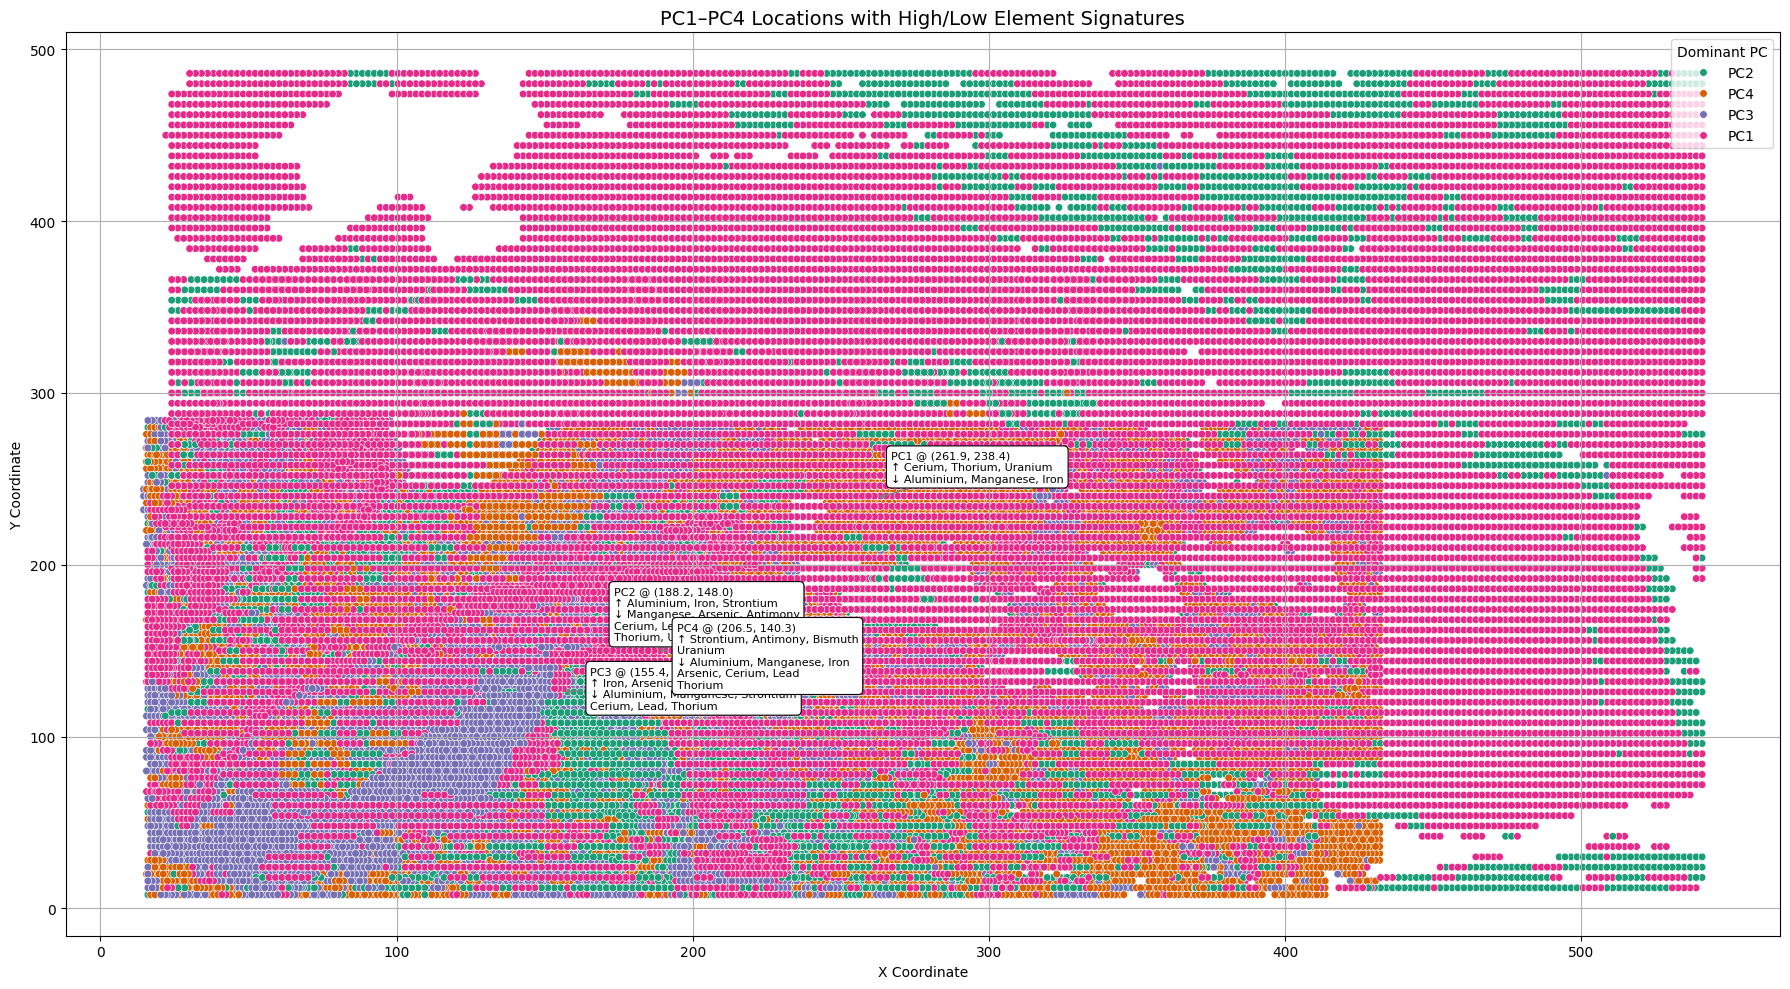

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# Define custom offsets for each PC label to prevent overlap
arrow_offsets = {
    "PC1": (5, 10),
    "PC2": (-15, 8),
    "PC3": (10, -10),
    "PC4": (-12, -12),
}

# Setup figure
plt.figure(figsize=(18, 10))
scatter = sns.scatterplot(data=pcs_df, x="x", y="y", hue="PC_max", palette="Dark2", s=30)

# Annotate each PC
for i, row in pc_locations.iterrows():
    pc = row["PC_max"]
    x, y = row["x"], row["y"]
    
    high_elements = pc_element_info[pc]["High"]
    low_elements = pc_element_info[pc]["Low"]

    # Format text in multiple lines to avoid long box
    high_text = '\n'.join([', '.join(high_elements[i:i+3]) for i in range(0, len(high_elements), 3)])
    low_text = '\n'.join([', '.join(low_elements[i:i+3]) for i in range(0, len(low_elements), 3)])
    
    text = f"{pc} @ ({x:.1f}, {y:.1f})\n↑ {high_text}\n↓ {low_text}"
    
    # Get the offset for this PC
    dx, dy = arrow_offsets.get(pc, (5, 5))  # Default offset
    xytext = (x + dx, y + dy)
    
    plt.annotate(
        text,
        xy=(x, y),
        xytext=xytext,
        arrowprops=dict(arrowstyle="->", color="gray", lw=1),
        bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="black", lw=0.8),
        fontsize=8,
        ha="left"
    )

# Final touches
plt.title("PC1–PC4 Locations with High/Low Element Signatures", fontsize=14)
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend(title="Dominant PC", loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()
